In [1]:
import sys
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
from sedfitter.sed import SEDCube
import pystellibs
from astropy.table import Table
from lampe.plots import corner, mark_point, nice_rc

In [2]:
mpl.rcdefaults()
plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings

In [3]:
sys.path.append('dev/')
sys.path.append('/Users/ratzenboe/Documents/work/projects/DomainAdapterSBI/dev_da/sed_basis/')

from dev.photometry import Photometry
from rebin_spectrum import rebin_spectrum_flux_conserving

In [4]:
def fitzpatrick99_k_lambda(wav_aa, Rv=3.1):
    x = 1e4 / wav_aa  # inverse micron
    k = np.zeros_like(x)
    # UV regime
    uv_mask = x >= 1e4 / 2700.
    x0, gamma = 4.596, 0.99
    c3, c4, c5 = 3.23, 0.41, 5.9
    c2 = -0.824 + 4.717 / Rv
    c1 = 2.030 - 3.007 * c2

    y = x[uv_mask]
    d = y**2 / ((y**2 - x0**2)**2 + y**2 * gamma**2)
    f = np.zeros_like(y)
    f[y >= c5] = 0.5392 * (y[y >= c5] - c5)**2 + 0.05644 * (y[y >= c5] - c5)**3
    k[uv_mask] = c1 + c2 * y + c3 * d + c4 * f
    # Spline anchors for UV/optical transition
    x_uv_spline = 1e4 / np.array([2700., 2600.])
    d_uv = x_uv_spline**2 / ((x_uv_spline**2 - x0**2)**2 + x_uv_spline**2 * gamma**2)
    k_uv_spline = c1 + c2 * x_uv_spline + c3 * d_uv
    # Optical/IR anchors
    anchors_x = 1e4 / np.array([np.inf, 26500., 12200., 6000., 5470., 4670., 4110.])
    anchors_k = np.array([
        0.,
        0.26469 * Rv / 3.1,
        0.82925 * Rv / 3.1,
        -0.422809 + 1.00270 * Rv + 2.13572e-04 * Rv**2,
        -5.13540e-02 + 1.00216 * Rv - 7.35778e-05 * Rv**2,
        0.700127 + 1.00184 * Rv - 3.32598e-05 * Rv**2,
        1.19456 + 1.01707 * Rv - 5.46959e-03 * Rv**2 + 7.97809e-04 * Rv**3 - 4.45636e-05 * Rv**4
    ]) - Rv

    anchors_x = np.concatenate([anchors_x, x_uv_spline])
    anchors_k = np.concatenate([anchors_k, k_uv_spline])
    # Sort anchors (needed for np.interp)
    sort_idx = np.argsort(anchors_x)
    anchors_x = anchors_x[sort_idx]
    anchors_k = anchors_k[sort_idx]
    # Interpolate optical/IR regime
    y = x[~uv_mask]
    k[~uv_mask] = np.interp(y, anchors_x, anchors_k)
    k_lam = k + Rv
    return k_lam / 3.1

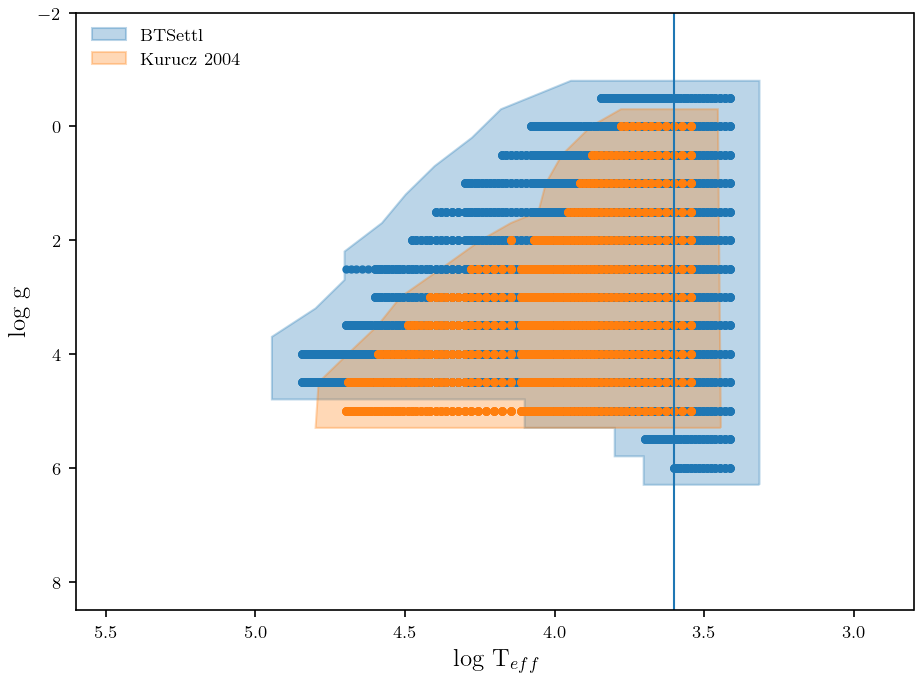

In [5]:
# Combine 2 libraries by priority order
lib = pystellibs.BTSettl() + pystellibs.Kurucz()
for osl in lib._olist:
    l = plt.plot(osl.logT, osl.logg, 'o')[0]
    osl.plot_boundary(color=l.get_color(), dlogT=0.1, dlogg=0.3, alpha=0.3,
                      label=osl.name)

plt.xlim(5.6, 2.8)
plt.ylim(8.5, -2)
plt.axvline(np.log10(4000))
plt.xlabel('log T$_{eff}$')
plt.ylabel('log g')
plt.tight_layout()

plt.legend(frameon=False, loc='upper left')

In [6]:
def flam_from_atmos(logg, logT, logL, Z, spec_lib, distances_pc=None):
    points = np.array([logT, logg])
    isin_param_range = spec_lib.points_inside(points.T)
    wave, specs = spec_lib.generate_individual_spectra(
        logT=logT[isin_param_range],
        logg=logg[isin_param_range],
        logL=logL[isin_param_range],
        Z=Z[isin_param_range],
    )
    # Transform the spectra to astropy units
    # First make sure the units are correct
    wave = wave.to('Angstrom')
    specs = specs.to('erg / (s * Angstrom)')
    # now transform to astropy units
    wave_ap = wave.magnitude * u.AA
    specs_ap = specs.magnitude * u.erg / u.s / u.AA
    # to avoid having to carry the mask around, we save NaNs for the spectra outside the range
    specs_all = np.full((len(logT), len(wave)), np.nan) * u.erg / u.s / u.AA
    specs_all[isin_param_range] = specs_ap
    # Transform generic spectra to observed fluxes at Earth
    if distances_pc is None:
        distances_pc = np.full(logL.shape[0], 1000) * u.pc
    distance_cm = distances_pc.to(u.cm)
    flam = specs_all / (4 * np.pi * distance_cm[..., None] ** 2)
    return wave_ap, flam

In [7]:
n_pts = 5
spec_lib = pystellibs.BTSettl()

logg = np.array(n_pts*[4.0])
logT = np.linspace(3.2, 5.0, n_pts)
# min/max logL: (-3.83, 6.85)
logL = np.linspace(-3.8, 6.8, n_pts)
Z = np.array(n_pts*[0.0])

# Plot spectra

(1e-30, 5e-07)

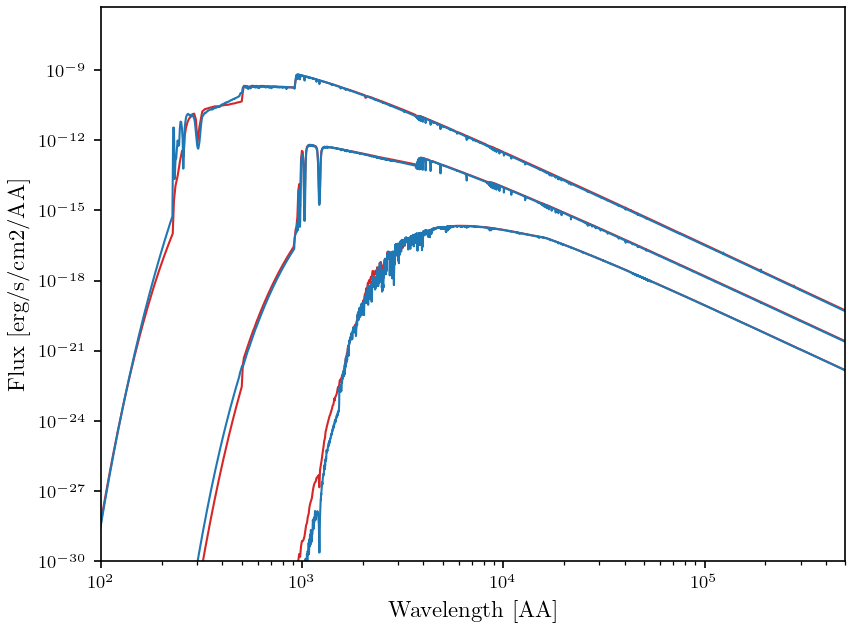

In [8]:
idx_set = [1,2,3]
for spec_lib, col in zip([pystellibs.Kurucz(), pystellibs.BTSettl()], ['tab:red', 'tab:blue']):
    wave_ap, flam = flam_from_atmos(logg, logT, logL, Z, spec_lib)
    for idx in idx_set:
        plt.loglog(wave_ap, flam[idx], col, lw=1, alpha=1)

plt.xlabel('Wavelength [AA]', fontsize=11)
plt.ylabel('Flux [erg/s/cm2/AA]', fontsize=11)
plt.xlim(100, 5e5)
plt.ylim(1e-30, 5e-7)

In [9]:
wave_kur, flam_kur = flam_from_atmos(logg, logT, logL, Z, pystellibs.Kurucz())
wave_bt, flam_bt = flam_from_atmos(logg, logT, logL, Z, pystellibs.BTSettl())

In [10]:
wave_bt.size, wave_kur.size

(12325, 1221)

In [11]:
wave_yso = np.array([4.83863172e+07, 4.53135115e+07, 4.24358464e+07, 3.97409293e+07,
       3.72171547e+07, 3.48536542e+07, 3.26402494e+07, 3.05674083e+07,
       2.86262044e+07, 2.68082780e+07, 2.51058002e+07, 2.35114394e+07,
       2.20183296e+07, 2.06200407e+07, 1.93105511e+07, 1.80842215e+07,
       1.69357708e+07, 1.58602533e+07, 1.48530372e+07, 1.39097850e+07,
       1.30264347e+07, 1.21991822e+07, 1.14244649e+07, 1.06989465e+07,
       1.00195027e+07, 9.38320744e+06, 8.78732052e+06, 8.22927580e+06,
       7.70667009e+06, 7.21725280e+06, 6.75891629e+06, 6.32968675e+06,
       5.92771572e+06, 5.55127213e+06, 5.19873485e+06, 4.86858568e+06,
       4.55940286e+06, 4.26985491e+06, 3.99869489e+06, 3.74475507e+06,
       3.50694187e+06, 3.28423116e+06, 3.07566384e+06, 2.88034174e+06,
       2.69742369e+06, 2.52612198e+06, 2.36569890e+06, 2.21546359e+06,
       2.07476908e+06, 1.94300947e+06, 1.81961734e+06, 1.70406131e+06,
       1.59584375e+06, 1.49449862e+06, 1.39958947e+06, 1.31070760e+06,
       1.22747023e+06, 1.14951890e+06, 1.07651793e+06, 1.00815293e+06,
       9.44129499e+05, 8.84171918e+05, 8.28021983e+05, 7.75437888e+05,
       7.26193182e+05, 6.80075794e+05, 6.36887121e+05, 5.96441175e+05,
       5.58563775e+05, 5.23091806e+05, 4.89872508e+05, 4.58762823e+05,
       4.29628781e+05, 4.02344915e+05, 3.76793729e+05, 3.52865189e+05,
       3.30456247e+05, 3.09470400e+05, 2.89817274e+05, 2.71412232e+05,
       2.54176015e+05, 2.38034396e+05, 2.22917861e+05, 2.08761311e+05,
       1.95503784e+05, 1.83088184e+05, 1.71461045e+05, 1.60572296e+05,
       1.50375044e+05, 1.40825375e+05, 1.31882165e+05, 1.23506899e+05,
       1.15663510e+05, 1.08318220e+05, 1.01439399e+05, 9.49974212e+04,
       8.89645459e+04, 8.33147924e+04, 7.80238302e+04, 7.30688742e+04,
       6.84285860e+04, 6.40829825e+04, 6.00133494e+04, 5.62021612e+04,
       5.26330050e+04, 4.92905105e+04, 4.61602834e+04, 4.32288434e+04,
       4.04835665e+04, 3.79126303e+04, 3.55049631e+04, 3.32501965e+04,
       3.11386203e+04, 2.91611412e+04, 2.73092433e+04, 2.55749513e+04,
       2.39507968e+04, 2.24297853e+04, 2.10053666e+04, 1.96714066e+04,
       1.84221607e+04, 1.72522489e+04, 1.61566332e+04, 1.51305953e+04,
       1.41697166e+04, 1.32698592e+04, 1.24271479e+04, 1.16379534e+04,
       1.08988774e+04, 1.02067368e+04, 9.55855108e+03, 8.95152885e+03,
       8.38305596e+03, 7.85068434e+03, 7.35212133e+03, 6.88521990e+03,
       6.44796936e+03, 6.03848672e+03, 5.65500854e+03, 5.29588341e+03,
       4.95956476e+03, 4.64460425e+03, 4.34964552e+03, 4.07341835e+03,
       3.81473317e+03, 3.57247596e+03, 3.34560346e+03, 3.13313866e+03,
       2.93416657e+03, 2.74783034e+03, 2.57332752e+03, 2.40990662e+03,
       2.25686388e+03, 2.11354021e+03, 1.97931841e+03, 1.85362046e+03,
       1.73590504e+03, 1.62566522e+03, 1.52242625e+03, 1.42574355e+03,
       1.33520074e+03, 1.25040792e+03, 1.17099992e+03, 1.09663478e+03,
       1.02699225e+03, 9.61772411e+02, 9.00694405e+02, 8.43495198e+02,
       7.89928467e+02, 7.39763526e+02, 6.92784344e+02, 6.48788607e+02,
       6.07586848e+02, 5.69001635e+02, 5.32866802e+02, 4.99026736e+02,
       4.67335707e+02, 4.37657237e+02, 4.09863519e+02, 3.83834860e+02,
       3.59459168e+02, 3.36631471e+02, 3.15253462e+02, 2.95233078e+02,
       2.76484102e+02, 2.58925793e+02, 2.42482535e+02, 2.27083518e+02,
       2.12662426e+02, 1.99157155e+02, 1.86509546e+02, 1.74665131e+02,
       1.63572904e+02, 1.53185096e+02, 1.43456973e+02, 1.34346642e+02,
       1.25814867e+02, 1.17824909e+02, 1.10342359e+02, 1.03334993e+02])

In [12]:
def regrid_spectrum(wave_old, flux_old, wave_new):
    # Compute bin edges for both grids
    edges_old = _centers_to_edges(wave_old)
    edges_new = _centers_to_edges(wave_new)

    # Integrate flux in original bins: F_i * dλ_i
    dwave_old = np.diff(edges_old)
    cumflux = np.concatenate([[0], np.cumsum(flux_old * dwave_old)])

    # Interpolate cumulative flux at new bin edges
    cumflux_new = np.interp(edges_new, edges_old, cumflux)

    # Flux in each new bin divided by new bin width
    dwave_new = np.diff(edges_new)
    flux_new = np.diff(cumflux_new) / dwave_new

    return flux_new

def _centers_to_edges(centers):
    """Convert bin centers to bin edges."""
    edges = np.zeros(len(centers) + 1)
    edges[1:-1] = 0.5 * (centers[:-1] + centers[1:])
    # Extrapolate first and last edges
    edges[0] = centers[0] - 0.5 * (centers[1] - centers[0])
    edges[-1] = centers[-1] + 0.5 * (centers[-1] - centers[-2])
    return edges

In [13]:
wave_kur, flam_kur = flam_from_atmos(logg, logT, logL, Z, pystellibs.Kurucz())
wave_bt, flam_bt = flam_from_atmos(logg, logT, logL, Z, pystellibs.BTSettl())

In [14]:
import numpy as np
from scipy.fft import rfft, irfft

def smooth_and_regrid_log(wave_old, flux_old, wave_new):
    """Version for log-spaced grids where R = λ/Δλ is roughly constant."""
    lnw_old = np.log(wave_old)
    lnw_new = np.log(wave_new)

    dlnw_old = np.median(np.diff(lnw_old))
    dlnw_new = np.median(np.diff(lnw_new))

    sigma_pixels = (dlnw_new / dlnw_old) / 2.355

    n = len(flux_old)
    freq = np.fft.rfftfreq(n)
    kernel_ft = np.exp(-2 * (np.pi * sigma_pixels * freq)**2)
    flux_smooth = irfft(rfft(flux_old) * kernel_ft, n=n)

    flux_new = np.interp(lnw_new, lnw_old, flux_smooth)

    return flux_new

In [15]:
f_old = flam_kur[2].value
w_old = wave_kur.value
w_new = np.sort(wave_yso)
# new_flux = regrid_spectrum(wave_old=w_old, flux_old=f_old, wave_new=np.sort(wave_yso))
new_flux = smooth_and_regrid_log(wave_old=w_old, flux_old=f_old, wave_new=w_new)

(1e-18, 1e-11)

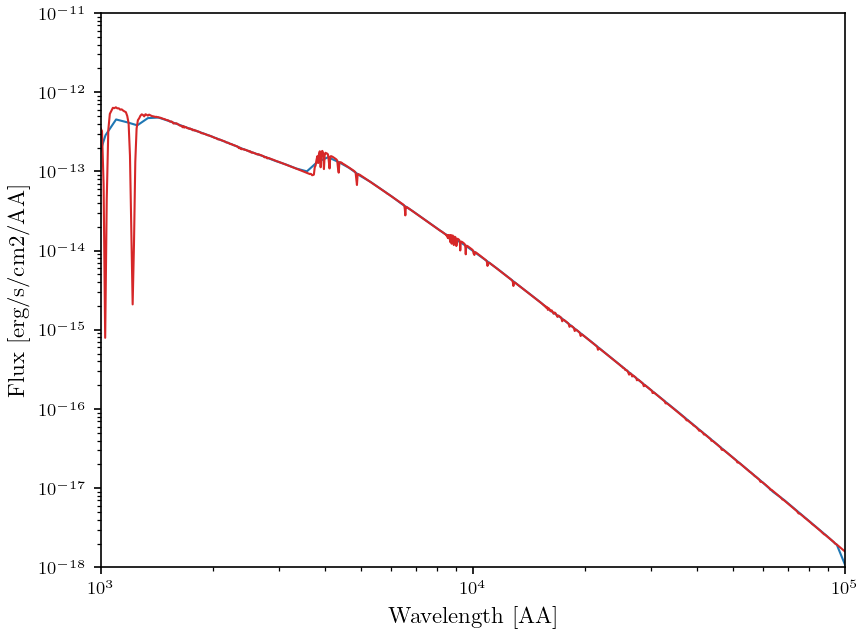

In [16]:
plt.loglog(np.sort(wave_yso), new_flux, lw=1, c='tab:blue')
plt.loglog(np.sort(wave_kur.value), f_old, lw=1, c='tab:red')
plt.xlabel('Wavelength [AA]', fontsize=11)
plt.ylabel('Flux [erg/s/cm2/AA]', fontsize=11)
plt.xlim(1000, 1e5)
plt.ylim(1e-18, 1e-11)

In [17]:
# Load YSO model

In [18]:
t_params = Table.read('/Users/ratzenboe/Downloads/r+24_models-1.2 2/s---s-i/parameters.fits')
sed_cube = SEDCube.read('/Users/ratzenboe/Downloads/r+24_models-1.2 2/s---s-i/flux.fits')
print(list(t_params.columns))

['MODEL_NAME', 'star.radius', 'star.temperature', 'scattering', 'inclination', 'Source Luminosity', 'Spectral Index']


In [19]:
cut = (t_params['star.radius'] != 0)
cut_idx = np.where(cut)[0]
# Remove the models which don't have any solutions
# t_params = t_params[cut_idx].to_pandas()
# Overwrite the SED cube with the numpy array
yso_sed = sed_cube.val.value[cut_idx]

In [20]:
from astropy.constants import c as c_light_speed

f_nu = yso_sed * u.mJy

wave_yso_new = sed_cube.wav.to(u.AA)
distance_pc = np.full(f_nu.shape[0], 1000) * u.pc
distance_kpc = distance_pc.to(u.kpc)
# Convert to erg/s/cm²/Hz
f_nu_cgs = f_nu.to(u.erg / u.s / u.cm**2 / u.Hz)
# Convert wavelength to cm
lam_cm = wave_yso_new.to(u.cm)
# Apply conversion
f_lambda = (f_nu_cgs * c_light_speed) / lam_cm**2
# Output in erg/s/cm²/Å (flam)
f_lambda = f_lambda.to(u.erg / u.s / u.cm**2 / u.AA)
# Factor in distance
f_lambda *= (u.kpc / distance_kpc[...,None,None]) ** 2

f_lambda = f_lambda[:,0,::-1]
wave_yso = np.sort(wave_yso)

# Photometry

In [21]:
phot_obj = Photometry(filter_names=["GAIA/GAIA3.Gbp", "GAIA/GAIA3.G", "GAIA/GAIA3.Grp", '2mass', 'wise', 'irac', 'ps1'])
k_lambda = fitzpatrick99_k_lambda(wave_yso, Rv=3.1)

In [22]:
flux_est = {}
transmission_band = {}
cl_aa = {}
zero_point_flux = {}
phot_cols = []
for pb in phot_obj._filter_bands:
    lam_filter_aa = pb.wavelength.to('AA').value
    transmit_filter = pb.transmit
    # rebin filter response on same wavelength grid
    transmit_filter_rebinned = np.interp(wave_yso, lam_filter_aa, transmit_filter, left=0., right=0.)
    transmission_band[pb.name] = transmit_filter_rebinned
    cl_aa[pb.name] = pb.cl.to('AA')
    phot_cols.append(pb.name)
    if pb.name.split('_')[0] in ['GALEX', 'SDSS', 'PS1']:
        zero_point_flux[pb.name] = pb.AB_zero_flux
    else:
        zero_point_flux[pb.name] = pb.Vega_zero_flux

filter_kernels = np.array([transmission_band[phot_name] for phot_name in phot_cols])
cl_phot = np.asarray([cl_aa[phot_name].value for phot_name in phot_cols])
zpts_phot = np.asarray([zero_point_flux[phot_name].value for phot_name in phot_cols])
# precompute filter relevant arrays
dw = np.gradient(wave_yso)[0]
lam_grid_x_dw = dw * wave_yso
lxf = lam_grid_x_dw * filter_kernels
b = np.sum(lxf, axis=1)[np.newaxis, :]

In [23]:
# Apply extinction
# Av_i = 1.0
# f_ext_t = f_lambda * np.exp(-k_lambda[np.newaxis, :] * Av_i) #[:, np.newaxis])
flux_in_filter_est = np.sum(lxf[np.newaxis, :, :] * f_lambda[:, np.newaxis, :], axis=-1) / b

(1e-19, 1e-09)

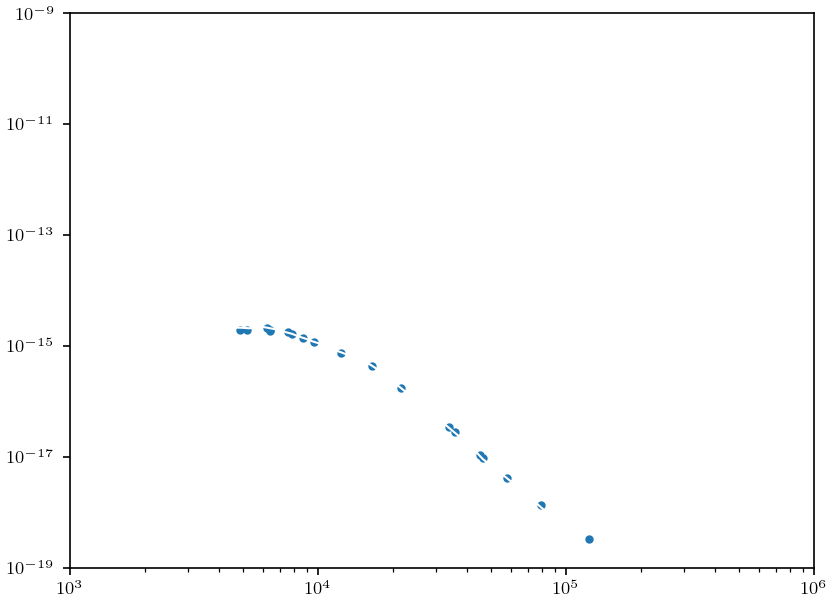

In [24]:
idx = 16

plt.loglog(wave_yso, f_lambda[idx], 'w-')
plt.scatter(cl_phot, flux_in_filter_est[idx])
plt.xlim(1000, 1e6)
plt.ylim(1e-19, 1e-9)

In [25]:
idx = 0
phot_cols[idx]

'GAIA_GAIA3.Gbp'

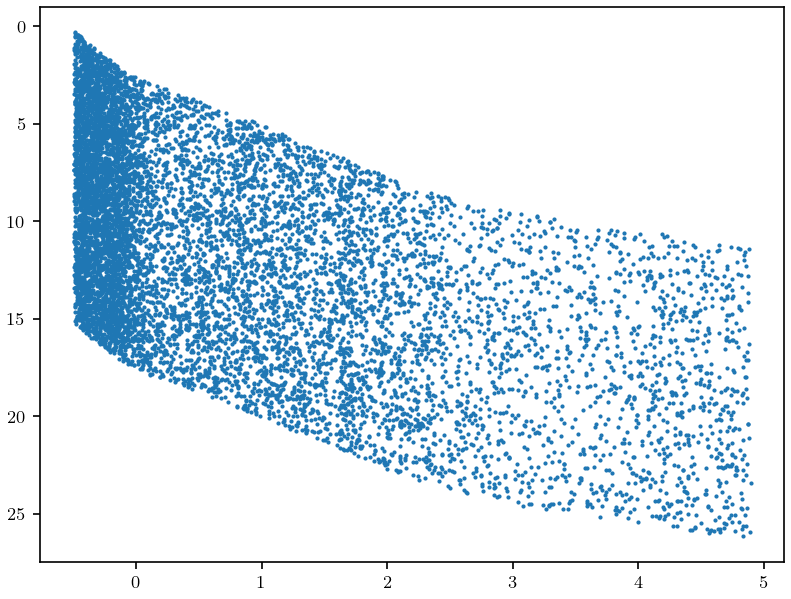

In [26]:
Gbp = -2.5 * np.log10(flux_in_filter_est[:,0] / zero_point_flux[phot_cols[0]])
G   = -2.5 * np.log10(flux_in_filter_est[:,1] / zero_point_flux[phot_cols[1]])
Grp = -2.5 * np.log10(flux_in_filter_est[:,2] / zero_point_flux[phot_cols[2]])

plt.scatter(Gbp - Grp, G, s=1)
plt.gca().invert_yaxis()

(1e-18, 1e-08)

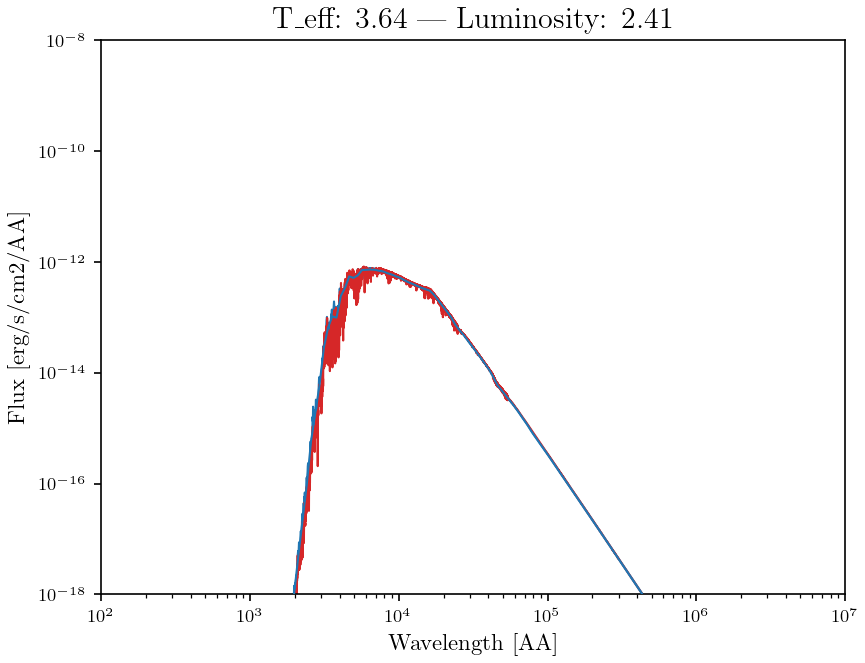

In [27]:
idx = 1010
plt.loglog(wave_yso, f_lambda[idx], zorder=10)
plt.xlabel('Wavelength [AA]', fontsize=11)
plt.ylabel('Flux [erg/s/cm2/AA]', fontsize=11)
df = t_params[['star.temperature', 'Source Luminosity']].to_pandas()
logT = np.array([np.log10(df["star.temperature"].values[idx])])
logL = np.array([np.log10(df["Source Luminosity"].values[idx])])
logg = np.array([4])
Z = np.array([1.52])
# Z = np.array([0.0152])  # solar
# Z = np.array([0.000152])  # [Fe/H] = -2

wave_kur, flam_kur = flam_from_atmos(logg, logT, logL, Z, pystellibs.Kurucz())
wave_bt, flam_bt = flam_from_atmos(logg, logT, logL, Z, pystellibs.BTSettl())
plt.loglog(wave_kur, flam_kur[0], lw=1, c='tab:blue')
plt.loglog(wave_bt, flam_bt[0], lw=1, c='tab:red')

# new_flux = smooth_and_regrid_log(wave_old=wave_kur.value, flux_old=flam_kur[0].value, wave_new=np.sort(wave_yso_new.value))
# plt.loglog(w_new, new_flux, lw=1, c='tab:green')

plt.scatter(cl_phot, flux_in_filter_est[idx], c='w')

plt.title(f'T_eff: {logT[0]:.2f} | Luminosity: {logL[0]:.2f}')
plt.xlim(100, 1e7)
plt.ylim(1e-18, 1e-8)

# Load Robitaille+2017
See if the original models also seem to be [Fe/H] = +2 instead of -2 as claimed by Richardson et al. 2024.

In [28]:
fpath = '/Users/ratzenboe/Downloads/s---s-i/flux.fits'

t_params_r17 = Table.read('/Users/ratzenboe/Downloads/s---s-i/parameters.fits')
sed_cube_r17 = SEDCube.read('/Users/ratzenboe/Downloads/r+24_models-1.2 2/s---s-i/flux.fits')

yso_sed_r17 = sed_cube_r17.val.value

f_nu = yso_sed_r17 * u.mJy
wave_yso_r17 = sed_cube_r17.wav.to(u.AA)
distance_pc = np.full(f_nu.shape[0], 1000) * u.pc
distance_kpc = distance_pc.to(u.kpc)
# Convert to erg/s/cm²/Hz
f_nu_cgs = f_nu.to(u.erg / u.s / u.cm**2 / u.Hz)
# Convert wavelength to cm
lam_cm = wave_yso_r17.to(u.cm)
# Apply conversion
f_lambda_r17 = (f_nu_cgs * c_light_speed) / lam_cm**2
# Output in erg/s/cm²/Å (flam)
f_lambda_r17 = f_lambda_r17.to(u.erg / u.s / u.cm**2 / u.AA)
# Factor in distance
f_lambda_r17 *= (u.kpc / distance_kpc[...,None,None]) ** 2

f_lambda_r17 = f_lambda_r17[:,0,::-1]
wave_yso_r17 = np.sort(wave_yso_r17)

In [29]:
# idx = 1016
# plt.loglog(wave_yso, f_lambda[idx], zorder=10)
# plt.loglog(wave_yso_r17, f_lambda_r17[idx], zorder=10)
# plt.xlim(100, 1e7)
# plt.ylim(1e-18, 1e-8)

In [57]:
np.arange(10_000)[t_params['star.temperature'] < 4000]

array([  14,   24,   28, ..., 9991, 9993, 9996])

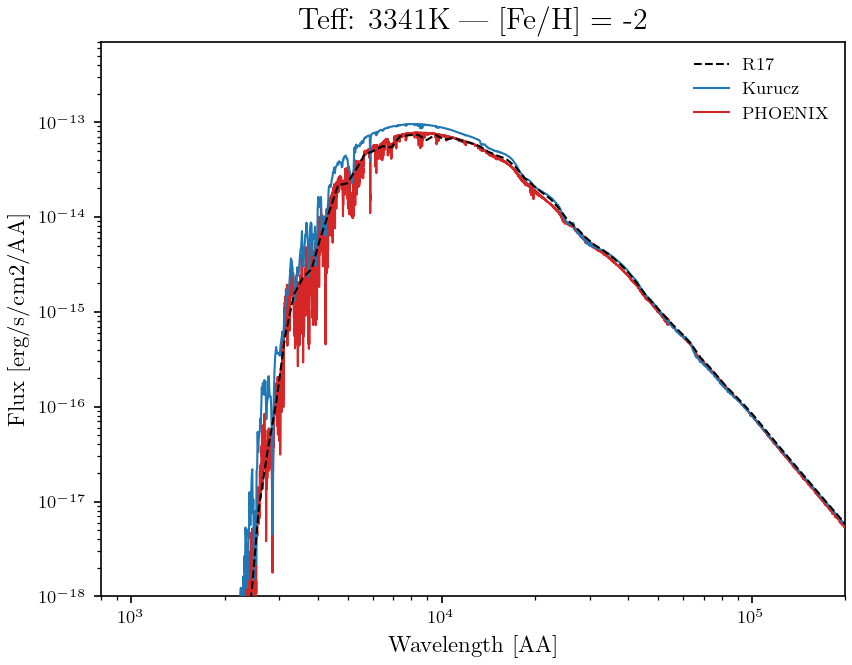

In [60]:
show_phot = False
show_r17 = False
show_kurucz = True
show_bt = True


idx = 28

plt.loglog(wave_yso, f_lambda[idx], zorder=10, c='k', lw=1, ls='--', label='R17')
if show_r17:
    plt.loglog(wave_yso_r17, f_lambda_r17[idx], zorder=10)

plt.xlabel('Wavelength [AA]', fontsize=11)
plt.ylabel('Flux [erg/s/cm2/AA]', fontsize=11)
df = t_params[['star.temperature', 'Source Luminosity']].to_pandas()
logT = np.array([np.log10(df["star.temperature"].values[idx])])
logL = np.array([np.log10(df["Source Luminosity"].values[idx])])
logg = np.array([4])
# Z = np.array([1.52])
# Z = np.array([0.0152])  # solar
Z = np.array([0.000152])  # [Fe/H] = -2

wave_kur, flam_kur = flam_from_atmos(logg, logT, logL, Z, pystellibs.Kurucz())
wave_bt, flam_bt = flam_from_atmos(logg, logT, logL, Z, pystellibs.BTSettl())
if show_kurucz:
    plt.loglog(wave_kur, flam_kur[0], lw=1, c='tab:blue', label='Kurucz', zorder=9)
if show_bt:
    plt.loglog(wave_bt, flam_bt[0], lw=1, c='tab:red', label='PHOENIX', zorder=8)

# new_flux = smooth_and_regrid_log(wave_old=wave_kur.value, flux_old=flam_kur[0].value, wave_new=np.sort(wave_yso_new.value))
# plt.loglog(w_new, new_flux, lw=1, c='tab:green')

if show_phot:
    plt.scatter(cl_phot, flux_in_filter_est[idx], c='w')

plt.title(f'Teff: {10**logT[0]:.0f}K | [Fe/H] = -2')
plt.xlim(800, 2e5)
plt.ylim(1e-18, 7e-13)
plt.legend(frameon=False)
plt.savefig('/Users/ratzenboe/Desktop/R17_T<4000K_kurucz-phoenix_comparison_feh-2.jpeg', bbox_inches='tight', dpi=300)
plt.show()